In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 5.0 MB/s 


In [4]:
pip install patool

     |████████████████████████████████| 77 kB 3.2 MB/s 


In [6]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/train_subset.rar", outdir="/content/sample_data")

patool: Extracting /content/drive/MyDrive/train_subset.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/train_subset.rar
patool:     with cwd='/content/sample_data'
patool: ... /content/drive/MyDrive/train_subset.rar extracted to `/content/sample_data'.


'/content/sample_data'

In [7]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/test.zip", outdir="/content/sample_data")

patool: Extracting /content/drive/MyDrive/test.zip ...
patool: running /usr/bin/7z x -o/content/sample_data -- /content/drive/MyDrive/test.zip
patool: ... /content/drive/MyDrive/test.zip extracted to `/content/sample_data'.


'/content/sample_data'

In [8]:
%cp -av /content/sample_data/train_set/00000 /content/sample_data/test

'/content/sample_data/train_set/00000' -> '/content/sample_data/test/00000'
'/content/sample_data/train_set/00000/FLAIR' -> '/content/sample_data/test/00000/FLAIR'
'/content/sample_data/train_set/00000/FLAIR/Image-1.dcm' -> '/content/sample_data/test/00000/FLAIR/Image-1.dcm'
'/content/sample_data/train_set/00000/FLAIR/Image-10.dcm' -> '/content/sample_data/test/00000/FLAIR/Image-10.dcm'
'/content/sample_data/train_set/00000/FLAIR/Image-100.dcm' -> '/content/sample_data/test/00000/FLAIR/Image-100.dcm'
'/content/sample_data/train_set/00000/FLAIR/Image-101.dcm' -> '/content/sample_data/test/00000/FLAIR/Image-101.dcm'
'/content/sample_data/train_set/00000/FLAIR/Image-102.dcm' -> '/content/sample_data/test/00000/FLAIR/Image-102.dcm'
'/content/sample_data/train_set/00000/FLAIR/Image-103.dcm' -> '/content/sample_data/test/00000/FLAIR/Image-103.dcm'
'/content/sample_data/train_set/00000/FLAIR/Image-104.dcm' -> '/content/sample_data/test/00000/FLAIR/Image-104.dcm'
'/content/sample_data/train_se

In [9]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset

In [10]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import glob

In [11]:
lables = os.listdir('/content/sample_data/train_set')

In [12]:
l =[] 
for x in lables:
  y = x.lstrip('0')
  if y == '':
    l.append(0)
  else:  
    l.append(int(y))


In [13]:
lables_t = os.listdir('/content/sample_data/test')

In [14]:
l1 =[] 
for x in lables_t:
  y = x.lstrip('0')
  if y == '':
    l1.append(0)
  else:  
    l1.append(int(y))

In [15]:
train_label = pd.read_csv('/content/drive/MyDrive/train_labels.csv')



In [16]:
target_train = []
for x in l:
  target_train.append(train_label[train_label['BraTS21ID']==x]['MGMT_value'])

In [17]:
target_test = []
for x in l1:
  target_test.append(train_label[train_label['BraTS21ID']==x]['MGMT_value'])

In [19]:
target_train = np.array(target_train)
target_test  = np.array(target_test )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [21]:
tain_set_org_path = '/content/sample_data/train_set'
l = os.listdir(tain_set_org_path)
path5=[]
for x in l:
  path1 = os.path.join(tain_set_org_path,x)
  path2 = os.listdir(path1)
  for z in path2:
    path3 = os.path.join(path1,z)
    path4 = os.listdir(path3)
    for y in path4:
      path5.append(os.path.join(path3,y))




In [22]:
test_set_org_path = '/content/sample_data/test'
l = os.listdir(test_set_org_path)
path_t=[]
for x in l:
  path1 = os.path.join(test_set_org_path,x)
  path2 = os.listdir(path1)
  for z in path2:
    path3 = os.path.join(path1,z)
    path4 = os.listdir(path3)
    for y in path4:
      path_t.append(os.path.join(path3,y))


In [23]:
NUM_IMAGES_3D = 64
TRAINING_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
IMAGE_SIZE = 64
N_EPOCHS = 15
do_valid = True
n_workers = 4


In [24]:
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array

    if rotate > 0:
        rot_choices = [
            0,
            cv2.ROTATE_90_CLOCKWISE,
            cv2.ROTATE_90_COUNTERCLOCKWISE,
            cv2.ROTATE_180,
        ]
        data = cv2.rotate(data, rot_choices[rotate])

    data = cv2.resize(data, (img_size, img_size))
    return data

In [25]:
from google.colab.patches import cv2_imshow
def subset_of_data_set(path5):
  data = []
  for x in path5:
    num_imgs = NUM_IMAGES_3D
    img_size=IMAGE_SIZE
    out = [load_dicom_image(x)]
    img3d = np.stack(out).T
    if img3d.shape[-1] < num_imgs:
      n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
      img3d = np.concatenate((img3d, n_zero), axis=-1)
    if np.min(img3d) < np.max(img3d):
      img3d = img3d - np.min(img3d)
      img3d = img3d / np.max(img3d)
    data.append(out)    
  return np.array(data)



In [26]:
def subset_of_data_set1(path5):
  data = []
  for x in path5:
    out = [load_dicom_image(x)]
    data.append(out)    
  return np.array(data)

In [27]:
data = subset_of_data_set1(path5[0:-1:3])
data_test = subset_of_data_set1(path_t)

In [28]:
data.shape

(6491, 1, 64, 64)

In [29]:
data_test.shape

(1704, 1, 64, 64)

In [30]:
data1 = data.reshape(data.shape[0],data.shape[-1],data.shape[-2],1)

In [31]:
data2 = data_test.reshape(data_test.shape[0],data_test.shape[-1],data_test.shape[-2],1)

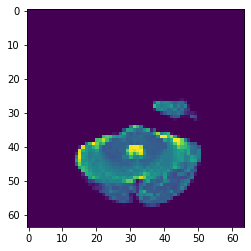

In [43]:
plt.imshow(data1[10].reshape(64,64))


In [33]:
y1 =[]
for i  in range(len(path5[0:-1:3])):
  y = path5[i].split('/')[-3].lstrip('0')
  if y == '':
    y1.append(0)
  else:  
    y1.append(int(y))



In [34]:
y2 =[]
for i  in range(len(path_t)):
  y = path5[i].split('/')[-3].lstrip('0')
  if y == '':
    y2.append(0)
  else:  
    y2.append(int(y))



In [35]:
target_train1 = []
for x in y1:
  target_train1.append(train_label[train_label['BraTS21ID']==x]['MGMT_value'].values)

In [36]:
target_test1 = []
for x in y2:
  target_test1.append(train_label[train_label['BraTS21ID']==x]['MGMT_value'].values)

In [37]:
target_train2 = np.array(target_train1)

In [38]:
target_test2 = np.array(target_test1)


In [39]:
print(target_train2.shape,target_test2.shape)

(6491, 1) (1704, 1)


In [53]:
one_hot_r=pd.get_dummies(target_train2.ravel(), prefix_sep='_', drop_first=False)
target1=np.array(one_hot_r)
target1.shape

(6491, 2)

In [50]:
one_hot_r1=pd.get_dummies(target_test2.ravel(), prefix_sep='_', drop_first=False)
target2=np.array(one_hot_r1)
target2.shape

(1704, 2)

In [54]:
from sklearn.model_selection import train_test_split
train_set,test_set,target_train,target_test= train_test_split(np.array(pd.concat([pd.DataFrame(data1.reshape(6491,64*64*1)),pd.DataFrame(data2.reshape(1704,64*64*1))])), np.array(pd.concat([pd.DataFrame(target1),pd.DataFrame(target2)])), test_size=0.3, random_state=42)

In [57]:
train_set = train_set.reshape(train_set.shape[0],64,64,1)
test_set = test_set.reshape(test_set.shape[0],64,64,1)

In [58]:
print(target_train.shape,target_test.shape)
print(test_set.shape)
print(train_set.shape)

(5736, 2) (2459, 2)
(2459, 64, 64, 1)
(5736, 64, 64, 1)


In [59]:
!pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=dddadcd9f7b067f88d368e87a88abff5583898568f40fdc74e3085627aeaa686
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet


In [60]:
import keras
import keras_resnet.models
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras import Model

In [61]:
shape, classes = (train_set.shape[1], train_set.shape[2], 1), 2
input = Input(shape=(train_set.shape[1], train_set.shape[2], 1))
model = keras_resnet.models.ResNet50(input, classes=classes)
last_layer = model.get_layer('pool5').output
last_layer1 = Dropout(0.40)(last_layer)
x= Flatten(name='flatten')(last_layer1)
x = Dropout(0.40)(x)
out = Dense(2, activation='softmax', name='output_layer')(x)
custom_resnet_model = Model(inputs=input,outputs= out)

custom_resnet_model.compile("adam", "binary_crossentropy", ["accuracy"])

In [62]:
custom_resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   3136        ['input_1[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (Activation)        (None, 32, 32, 64)   0           ['bn_conv1[0][0]']               
                                                                                              

In [64]:
shape, classes = (train_set.shape[1], train_set.shape[2], 1), 2
input = Input(shape=(train_set.shape[1], train_set.shape[2], 1))
model = keras_resnet.models.ResNet50(input, classes=classes)
last_layer = model.get_layer('pool5').output
last_layer1 = Dropout(0.25)(last_layer)
x= Flatten(name='flatten')(last_layer1)
x = Dropout(0.25)(x)
out = Dense(2, activation='softmax', name='output_layer')(x)
custom_resnet_model = Model(inputs=input,outputs= out)

custom_resnet_model.compile("adam", "binary_crossentropy", ["accuracy"])
hist = custom_resnet_model.fit(train_set, target_train, batch_size=1024,validation_batch_size=1024,epochs=400, verbose=1, validation_split=0.2)
custom_resnet_model.save("ResNet.h5")

Epoch 1/400
5/5 [==============================] - 9s 685ms/step - loss: 1.4264 - accuracy: 0.5473 - val_loss: 1230963.8750 - val_accuracy: 0.6220
Epoch 2/400
5/5 [==============================] - 2s 446ms/step - loss: 0.8051 - accuracy: 0.6044 - val_loss: 9464276.0000 - val_accuracy: 0.6220
Epoch 3/400
5/5 [==============================] - 2s 444ms/step - loss: 0.7257 - accuracy: 0.6273 - val_loss: 8580941.0000 - val_accuracy: 0.6220
Epoch 4/400
5/5 [==============================] - 2s 447ms/step - loss: 0.7144 - accuracy: 0.6367 - val_loss: 4993257.5000 - val_accuracy: 0.6220
Epoch 5/400
5/5 [==============================] - 2s 445ms/step - loss: 0.6815 - accuracy: 0.6521 - val_loss: 1192334.5000 - val_accuracy: 0.6220
Epoch 6/400
5/5 [==============================] - 2s 446ms/step - loss: 0.6339 - accuracy: 0.6835 - val_loss: 348293.9688 - val_accuracy: 0.6220
Epoch 7/400
5/5 [==============================] - 2s 446ms/step - loss: 0.5508 - accuracy: 0.7406 - val_loss: 139257.8

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


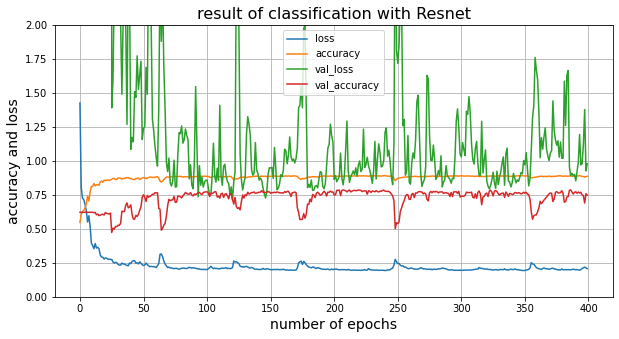

In [65]:
import pandas as pd
pd.DataFrame(hist.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.xlabel('number of epochs', fontsize=14)
plt.ylabel('accuracy and loss', fontsize=14)
plt.title('result of classification with Resnet',fontsize=16)
plt.show()

In [66]:
custom_resnet_model.evaluate(test_set,target_test)

77/77 [==============================] - 2s 19ms/step - loss: 0.9569 - accuracy: 0.7609


[0.9568655490875244, 0.7608783841133118]

In [68]:
!pip install scikit-plot

import scikitplot as skplt
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


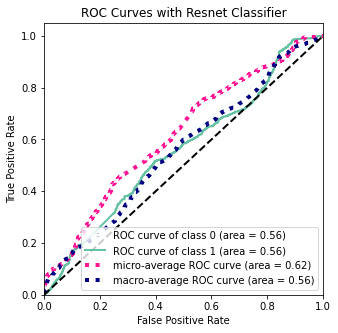

In [72]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
Y_pred = model.predict(test_set)
#y_pred = np.argmax(Y_pred, axis=1)
y_test1 =np.argmax(target_test, axis=1)
skplt.metrics.plot_roc_curve(y_test1,Y_pred,title="ROC Curves with Resnet Classifier", cmap='BuGn', figsize=[5,5])
plt.show()

Confusion Matrix
[[984 524]
 [526 425]]
Classification Report


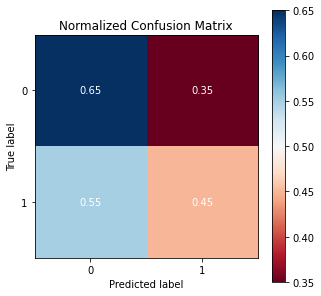

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
plt.rcParams["figure.figsize"] = (20,20)
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(np.argmax(target_test, axis=1), y_pred))
print('Classification Report')
skplt.metrics.plot_confusion_matrix(np.argmax(target_test, axis=1), y_pred, normalize=True,cmap='RdBu',figsize=[5,5])

In [75]:
pred = custom_resnet_model.predict(test_set)

In [76]:
predd = custom_resnet_model.predict(train_set)

In [77]:
pred_total = pd.concat([pd.DataFrame(predd),pd.DataFrame(pred)])
pred_total = np.array(pred_total)

In [78]:
pred_total1=[]
for x in pred_total:
  pred_total1.append(max(x))


In [79]:
pd.DataFrame(pred_total).value_counts()

0             1           
9.645498e-01  3.545011e-02    918
1.000000e+00  0.000000e+00    151
5.922059e-01  4.077941e-01     48
5.563466e-02  9.443653e-01     18
7.734349e-02  9.226565e-01     13
                             ... 
9.999993e-01  6.991179e-07      1
              6.991839e-07      1
              7.205740e-07      1
              7.209932e-07      1
5.985458e-31  1.000000e+00      1
Length: 6394, dtype: int64

In [80]:
pred_total1 = pd.DataFrame(pred_total1)

In [81]:
train_label['pred_total'] = pred_total1

In [82]:
train_label

,BraTS21ID,MGMT_value,pred_total
0,0,1,0.964550
1,2,1,1.000000
2,3,0,0.640823
3,5,1,1.000000
4,6,1,0.939198
...,...,...,...
580,1005,1,0.646346
581,1007,1,0.999999
582,1008,1,1.000000
583,1009,0,0.964550


In [83]:
pd.DataFrame(target_test).value_counts()

0  1
1  0    1508
0  1     951
dtype: int64

In [86]:
pred1=[]
for x in pred:
  pred1.append(max(x))

In [87]:
out = []
for x in pred:
  out.append(np.argmax(x))
out = np.array(out)

In [88]:
pd.DataFrame(out).value_counts()

0    1760
1     699
dtype: int64

<BarContainer object of 2 artists>

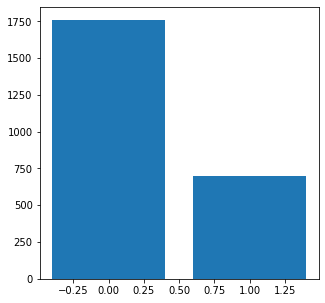

In [90]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
plt.bar(np.arange(0,2) ,pd.DataFrame(out).value_counts())